In [1]:
# http://www.physics.usyd.edu.au/teach_res/mp/mscripts/
# ns_izh002.m
import collections
from collections import OrderedDict

# Fast spiking cannot be reproduced as it requires modifications to the standard Izhi equation,
# which are expressed in this mod file.
# https://github.com/OpenSourceBrain/IzhikevichModel/blob/master/NEURON/izhi2007b.mod


reduced2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6))])


type2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('RTN',       (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('RTN_burst', (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('CH',        (50,  1.5,  -60, -40, 25, 0.03,   1, -40,  150,   3)),
  ('FS',        (20,  1.0,  -55, -40, 25, 0.2,   -2, -45,  -55,   5))])

import numpy as np
reduced_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])

#param_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])
#OrderedDict
for i,k in enumerate(reduced_dict.keys()):
    for v in type2007.values():
        reduced_dict[k].append(v[i])

explore_param = {k:(np.min(v),np.max(v)) for k,v in reduced_dict.items()}
param_ranges = OrderedDict(explore_param)


#IB = mparams[param_dict['IB']]
RS = {}
IB = {}
TC = {}
CH = {}
RTN_burst = {}
cells = OrderedDict([(k,[]) for k in ['RS','IB','CH','LTS','FS','TC','TC_burst','RTN','RTN_busrt']])
reduced_cells = OrderedDict([(k,[]) for k in ['RS','IB','LTS','TC','TC_burst']])

for index,key in enumerate(reduced_cells.keys()):
    reduced_cells[key] = {}
    for k,v in reduced_dict.items():
        reduced_cells[key][k] = v[index]

print(reduced_cells)
cells = reduced_cells

OrderedDict([('RS', {'k': 0.7, 'b': -2, 'vt': -40, 'vr': -60, 'd': 100, 'C': 100, 'c': -50, 'a': 0.03, 'vPeak': 35}), ('IB', {'k': 1.2, 'b': 5, 'vt': -45, 'vr': -75, 'd': 130, 'C': 150, 'c': -56, 'a': 0.01, 'vPeak': 50}), ('LTS', {'k': 1.0, 'b': 8, 'vt': -42, 'vr': -56, 'd': 20, 'C': 100, 'c': -53, 'a': 0.03, 'vPeak': 40}), ('TC', {'k': 1.6, 'b': 15, 'vt': -50, 'vr': -60, 'd': 10, 'C': 200, 'c': -60, 'a': 0.01, 'vPeak': 35}), ('TC_burst', {'k': 1.6, 'b': 15, 'vt': -50, 'vr': -60, 'd': 10, 'C': 200, 'c': -60, 'a': 0.01, 'vPeak': 35})])


In [2]:
model = None
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization import get_neab

from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
print(cells['TC'])
model.set_attrs(cells['TC'])
#dir(model._backend)
dir(model._backend.h)
#loc = 
#for sec in 
dir(model._backend.h.m_RS_RS_pop[0])#:

for sec in model._backend.h.m_RS_RS_pop[0].Section(0.5):
    sec.cm = (50/31.831)
    print(sec.cm)
    print(sec.area)
    print(sec.diam)

sec = model._backend.h.Section(model._backend.h.m_RS_RS_pop[0])    
sec.L, sec.diam = 6.3, 5 

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(cells['TC'])



{'k': 1.6, 'b': 15, 'vt': -50, 'vr': -60, 'd': 10, 'C': 200, 'c': -60, 'a': 0.01, 'vPeak': 35}
200.0
1.5707957651346172
<built-in method area of nrn.Segment object at 0x7fa4cb775788>
500.0


In [3]:

tests_,all_tests, observation,suite = get_neab.get_tests()

rheobase = all_tests[0].generate_prediction(model)
print(rheobase)

{'k': 1.6, 'd': 10, 'vt': -50, 'b': 15, 'vr': -60, 'C': 200, 'c': -60, 'a': 0.01, 'vPeak': 35} failed on
Try 1: SubMax = 42.5; SupraMin = 84.0
{'k': 1.6, 'd': 10, 'vt': -50, 'b': 15, 'vr': -60, 'C': 200, 'c': -60, 'a': 0.01, 'vPeak': 35} failed on
Try 2: SubMax = 67.4; SupraMin = 84.0
{'k': 1.6, 'd': 10, 'vt': -50, 'b': 15, 'vr': -60, 'C': 200, 'c': -60, 'a': 0.01, 'vPeak': 35} failed on
Try 3: SubMax = 74.0; SupraMin = 77.4
Try 4: SubMax = 74.7; SupraMin = 75.4
{'value': array(75.36800000000001) * pA}


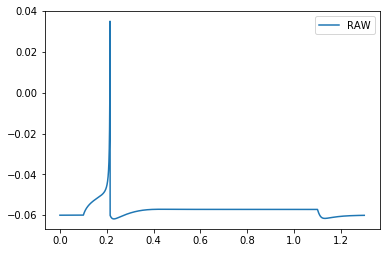

In [4]:


import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq

from neuronunit.optimization.data_transport_container import DataTC
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(cells['TC'])

iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] =75.36800000000001*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

model.inject_square_current(iparams)

plt.plot(model.get_membrane_potential().times,model.get_membrane_potential(),label='RAW')
plt.legend()
plt.show()


In [ ]:
from neuronunit.optimization import optimization_management as om
free_params = ['a','b','vr','k']
hc = {}
for k,v in cells['TC'].items():
    if k not in free_params:
        hc[k] = v
print(hc)
import pickle
TC_tests = pickle.load(open('thalamo_cortical_tests.p','rb'))    
ga_out, DO = om.run_ga(explore_param,3,TC_tests,free_params=free_params,hc = hc)


{'c': -60, 'd': 10, 'vt': -50, 'C': 200, 'vPeak': 35}
{'b': (-2, 15), 'k': (0.25, 1.6000000000000001), 'vr': (-75, -55), 'a': (0.01, 0.20000000000000001)}
[] []
not even to test runner getting


/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[<neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a44c60f0>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a45552b0>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a44c65f8>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a45557b8>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4cbd8ef28>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a4555470>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a44c6dd8>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a44c68d0>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4cbd8eac8>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a4555198>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a44c6630>, <neuronunit.optimization.data_transport_container.DataTC object at 0x7fa4a4

/opt/conda/lib/python3.5/site-packages/deap/tools/mutation.py:80: RuntimeWarning: invalid value encountered in double_scalars
  delta_q = val**mut_pow - 1.0
/opt/conda/lib/python3.5/site-packages/deap/tools/mutation.py:84: RuntimeWarning: invalid value encountered in double_scalars
  delta_q = 1.0 - val**mut_pow


(Pdb) offspring
[[-2, -75, 10, -55], [-2, -55, 1.6000000000000001, 200], [-2, -2, 1.6000000000000001, 200], [-2, -2, 10, -55], [15, -2, 10, 200], [0.20000000000000001, -2.0, 1.6000000000000001, -55], [0.20000000000000001, -1.8089069773903668, 10, -55], [15, -2.0, 1.6000000000000001, 200], [-2, -2, 10, 200], [0.01, -2.0, 10, 200], [-2, -2, 10, -55], [0.01, -2, 1.6000000000000001, 200], [0.20000000000000001, -1.9837641572526363, 10, 200], [15, 0.29480266263873922, 10, 200], [15, -75, 10, 200], [15, -55, 10, 200]]
(Pdb) len(offspring)
16
(Pdb) c


In [ ]:



def format_iparams(all_tests,rheobase):

    for t in all_tests[1:5]:
        DURATION = 500.0*pq.ms
        DELAY = 200.0*pq.ms

        obs = t.observation
        t.params = {}
        t.params['injected_square_current'] = {}
        t.params['injected_square_current']['delay']= DELAY
        t.params['injected_square_current']['duration'] = DURATION
        t.tparams['injected_square_current']['amplitude'] = -10*pq.pA
        
        
    for t in all_tests[-3::]:    
        t.params = {}
        DURATION = 1000.0*pq.ms
        DELAY = 100.0*pq.ms

        t.params['injected_square_current'] = {}
        t.params['injected_square_current']['delay']= DELAY
        t.params['injected_square_current']['duration'] = DURATION
        t.params['injected_square_current']['amplitude'] = rheobase['value']
    
    all_tests[0].params = all_tests[-1].params
    
    return all_tests

pt = format_iparams(all_tests,rheobase)
print([t.params['injected_square_current']['amplitude'] for t in pt[-3::] ])
print([t.params['injected_square_current']['amplitude'] for t in pt[0:5] ])



##
# * Get predictions from models.
## * Fake NeuroElectro Observations
## * Do roundtrip testing
##

In [ ]:
predictions = []
import dask.bag as db
# The rheobase has been obtained seperately and cannot be db mapped.
# Nested DB mappings dont work.
ptbag = db.from_sequence(pt[0::])

def obtain_predictions(t):    
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(cells['TC'])
    return t.generate_prediction(model)
predictions = list(ptbag.map(obtain_predictions).compute())
predictions.insert(0,rheobase)
print(predictions)    


In [ ]:
# having both means and values in dictionary makes it very irritating to iterate over.
# It's more harmless to demote means to values, than to elevate values to means.
# Simply swap key names: means, for values.
for p in predictions:
    if 'mean' in p.keys():
        p['value'] = p.pop('mean')
print(predictions)


In [ ]:
# make some new tests based on internally generated data 
# as opposed to experimental data.


TC_tests = copy.copy(all_tests)
for ind,t in enumerate(TC_tests):
    if 'mean' in t.observation.keys():
        t.observation['value'] = t.observation.pop('mean')
    pred =  predictions[ind]['value']
    try:
        pred = pred.rescale(t.units)
        t.observation['value'] = pred
    except:        
        t.observation['value'] = pred
    t.observation['mean'] = t.observation['value']
        
    print(t.observation['value'])
    
pickle.dump(TC_tests,open('thalamo_cortical_tests.p','wb'))    
    




In [ ]:
def hack_judge(test_and_models):
    (test, attrs) = test_and_models
    model = None
    obs = test.observation
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(attrs)
    test.generate_prediction(model)
    pred = test.generate_prediction(model)
    score = test.compute_score(obs,pred)
    try:
        print(obs['value'],pred['value'])
    except:
        print(obs['mean'],pred['mean'])
        
    return score

scores = []
for i,t in enumerate(TC_tests):
    test_and_models = (t,cells['TC'])
    score = hack_judge(test_and_models)
    scores.append(score)
print(scores[0].sort_key)    
print(scores[0])    



In [ ]:
print([s.sort_key for s in scores])
print([s.score for s in scores])

score = hack_judge((TC_tests[-3],cells['TC']))
print(score)

In [ ]:
scores = []
for t in TC_tests:
    test_and_models = (t,cells['RS'])
    score = hack_judge(test_and_models)
    scores.append(score)
print(scores[0].sort_key)    
print(scores[0])
print([s.sort_key for s in scores])


In [ ]:
import dask.bag as db
# The rheobase has been obtained seperately and cannot be db mapped.
# Nested DB mappings dont work.
from itertools import repeat
test_a_models = zip(TC_tests[1::],repeat(cells['RS']))
tc_bag = db.from_sequence(test_a_models)

scores = list(tc_bag.map(hack_judge).compute())
scores.insert(0,rheobase)
print(scores)    

In [ ]:
score = TC_tests[0].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
#print(model.get_spike_count())

In [ ]:
from neuronunit.optimization import optimization_management as opt
from neuronunit.models import ReducedModel

In [ ]:

cnt = 0
scores = []
tests_,all_tests, observation,suite = opt.get_neab.get_tests()
passive  = [ str('RestingPotentialTest'), str('CapacitanceTest'), str('TimeConstantTest'), str('InputResistanceTest') ]
firing_tests =  [ t for t in all_tests if str(t) not in passive ]
first_two = all_tests[0:2]
print(first_two)

for t in all_tests:
    score = t.judge(model,stop_on_error = False, deep_error = True)
    scores.append(score)
    print(score)
    print('score {0}'.format(score))
    if str('mean') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['mean']))
    if str('value') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['value']))
    cnt+=1
#http://www.physics